In [1]:
!pip install git+https://github.com/AI-Guru/ngdlm.git

##########################################################
# Import Python libraries libraries
##########################################################
import sys
import tqdm
import json
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import display as ld


##########################################################
# Import Machine Learning libraries
##########################################################
import tensorflow as tf
from tensorflow.keras.models import Model
tf.compat.v1.disable_eager_execution()
from sklearn import manifold


  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-1ify_fay
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-1ify_fay
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=c99bd8e9e84e2d3ea26f4d627cf2bab657d18a7571294c6ff1f9c3d2f90ceeba
  Stored in directory: /tmp/pip-ephem-wheel-cache-p2463d5_/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Mounted at /gdrive
/gdrive/MyDrive/sound-of-failure


In [3]:
%cd ../../..
drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/sound-of-failure

/
Mounted at /gdrive
/gdrive/My Drive/sound-of-failure


In [4]:
sys.path += ['src/00_utils', 'src/01_data_processing', 'src/02_modelling', 'src/03_modell_evaluation', 'src/04_visualization']

import spectrogram as spec
import train_test_split as splt
import train_model_autoencoder as train
import eval_model_autoencoder as eval
import threshold_recoloss as thres
import visualize_autoencoder as viz
import naming

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Read config files and set global variables

In [5]:
run_id = 'VAE_6dB_valve_id_00'

base_conf = train.read_config('conf/conf_base.ini')

conf_path = naming.get_conf_path(run_id)
param_conf = train.read_config(conf_path)

In [6]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
MODEL_NAME = param_conf.get('autoencoder', 'model_name')

if MODEL_NAME == 'lstmAE':
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'))
elif MODEL_NAME in ['AE', 'VAE']:
    LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
    NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
    NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'),
                   1)
else:
    print('Invalid model name.')


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Load saved tensorflow model for variational autoencoder


In [7]:
model_path = naming.get_model_path(run_id)
saved_model = train.load_saved_model(model_path)

# Load fitted scaler for variational autoencoder

In [8]:
path_saved_scaler = naming.get_scaler_path(run_id)
saved_scaler = spec.load_saved_scaler(path_saved_scaler)

In [9]:
saved_model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 20), (None, 20),  587740    
_________________________________________________________________
decoder (Functional)         (None, 64, 32, 1)         724865    
Total params: 1,312,605
Trainable params: 1,311,197
Non-trainable params: 1,408
_________________________________________________________________


#### Extract the encoder and decoder from the VAE

In [10]:
# Load encoder and decoder
encoder, decoder = viz.load_encoder_decoder(saved_model)

# Visualizations
## A. Visualization of the decoded space i.e. output from the decoder

In [11]:
normal_file = spec.get_normal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0]
abnormal_file = spec.get_abnormal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0]

#### 1. Visualize the normal and abnormal spectrograms

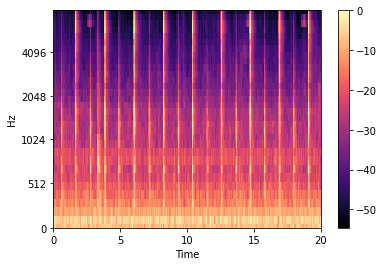

In [12]:
viz.plot_spectrogram(normal_file, sr=16000)

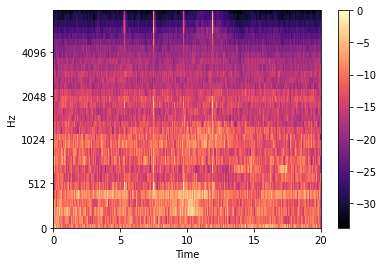

In [13]:
viz.plot_spectrogram(abnormal_file, sr=16000)

For the chosen normal spectrogram, break it up into slices by subsampling and extract the original and decoded slices.

In [14]:
orig_normal, decoded_normal = eval.decode_spectrogram(saved_model, saved_scaler, DIM, STEP, normal_file)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


#### 2. Plot the original and decoded spectrogram slices after subsampling for normal sound (first 10 slices)



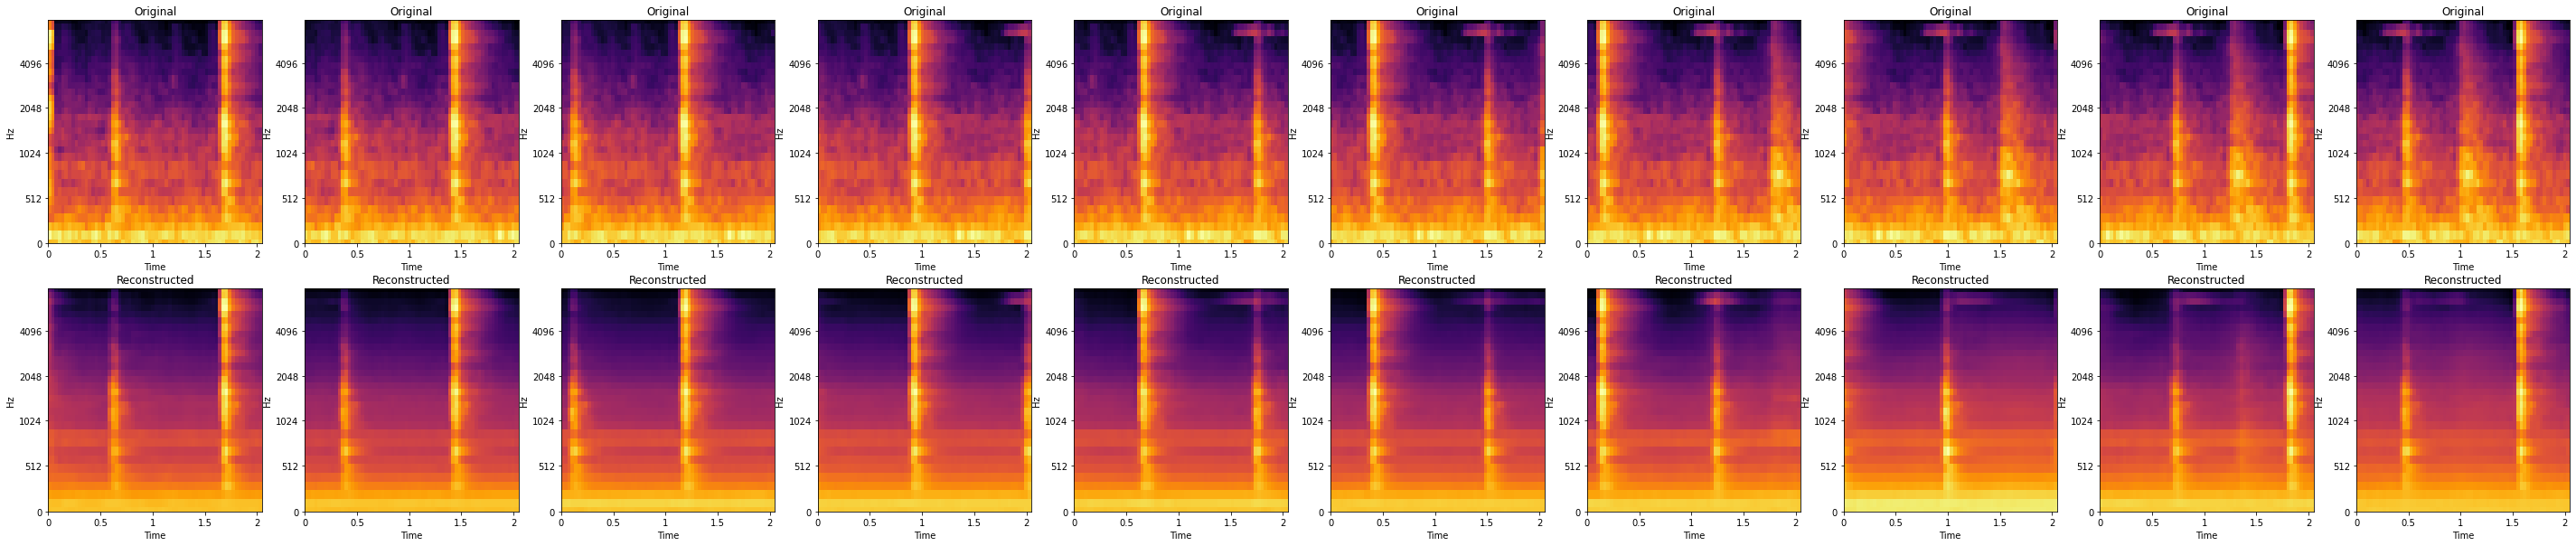

In [15]:
viz.render_predictions(orig_normal, decoded_normal, sr=16000)

For the chosen abnormal/anomalous spectrogram, break it up into slices by subsampling and extract the original and decoded slices.

In [16]:
orig_abnormal, decoded_abnormal = eval.decode_spectrogram(saved_model, saved_scaler, DIM, STEP, abnormal_file)

#### 3. Plot the original and decoded spectrogram slices after subsampling for anomalous/abnormal sound (first 10 slices)

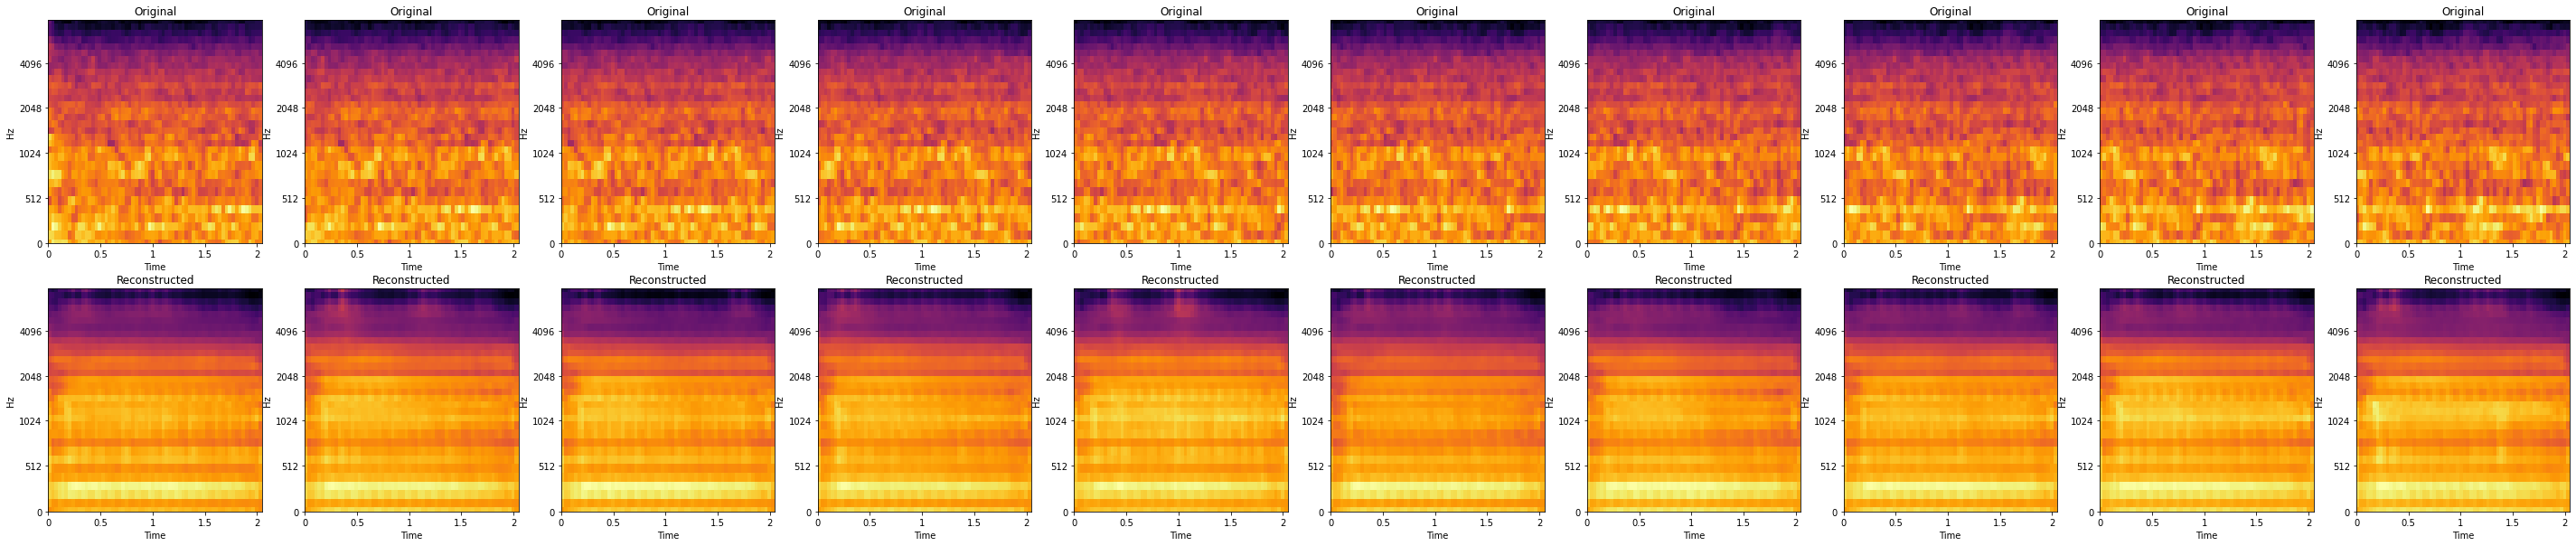

In [17]:
viz.render_predictions(orig_abnormal, decoded_abnormal, sr=16000)

## B. Visualizations for the encoded space i.e. output from the encoder

Choose a set of normal and abnormal files to encode into the latent space

In [18]:
set_of_normal_files = spec.get_normal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0:30]
set_of_abnormal_files = spec.get_abnormal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0:30]

#### Encode the spectrograms into the latent space and extract the mean and log_variance vectors

In [19]:
normal_mean, normal_logvar = viz.encode_test_files(encoder, saved_scaler, DIM, STEP, set_of_normal_files)
abnormal_mean, abnormal_logvar = viz.encode_test_files(encoder, saved_scaler, DIM, STEP, set_of_abnormal_files)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


In [20]:
encoded_test_data = np.concatenate([normal_mean, abnormal_mean])
test_labels = [0] * len(normal_mean) + [1] * len(abnormal_mean)

#### 4. Plot the latent space embeddings of the chosen normal and anomalous set of spectrograms

  - Label 1: Abnormal data
  - Label 0: Normal data

The Latent Space having 20 dimensions is further condensed into 2 dimensions for visualization using TSNE dimensionality reduction.

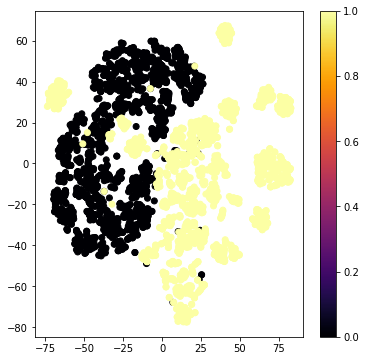

In [21]:
viz.Tsne_Projection_Of_Latent(encoded_test_data, test_labels)